# Table of Content:
* [Question 1: Machine Learning](#question1)
    - [Data Exploration](#dataexploration)
    - [Feature Engineering](#featureengineering)
    - [EDA and Feature Selection](#featureselection)
    - [Model Building](#modelbuilding)
    - [Model Evaluation and Results Presentation](#modelevaluation)
* [Question 2: Webscraping](#question2)

# Question 1: Machine Learning
<a class="anchor" id="question1"></a>

Describe your preferred approach for using machine learning to predict passenger survival using the Spaceship Titanic
dataset provided. Outline the necessary steps you would take to build and refine a model of your choice (eg. exploring the data, preparing it for analysis, dividing it into training and testing sets, checking for unusual data points, balancing minority classes, choosing important features, and fine-tuning the model with grid search). Assess the model's effectiveness using accuracy. Please provide a clear explanation of each step you have chosen. The information about the features can be found here: https://www.kaggle.com/competitions/spaceship-titanic/data


## Data Exploration
<a class="anchor" id="dataexploration"></a>

Some ideas refer to https://www.kaggle.com/code/computervisi/best-models-spaceship-titanic#Step-3:-Prepare-Data-for-Consumption

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
titanic = pd.read_csv('spaceship_titanic.csv')
titanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# create a copy of data to avoid poluting the original data
df = titanic.copy()
X = df.drop(['Transported'], axis=1)
y = df['Transported']

The dataset is well balanced.

In [6]:
# check for data balance
y.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

There is no duplicate in the dataset.

In [7]:
# check for duplicates
X.duplicated().sum()

0

There is a bunch of missing values across nearly all features.

In [8]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Train Test Split

To avoid data leakage, train-test split needs to be performed before feature engineering.

In [9]:
# train-test split with 20% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [10]:
datasets = [train, test, X]

Create Group feature from PassengerId; and Deck, Cabin_num and Side features from Cabin; and Expenditure capturing the total spending of a passenger; and Surname from the passenger's Name, which will be used for the following data processing steps.

In [11]:
# create new features
expenditure_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for df in datasets:
    df['Group'] = df['PassengerId'].str.split("_", expand=True)[0]
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    df['Expenditure'] = df[expenditure_features].sum(axis=1)
    df['Surname']=df['Name'].str.split().str[-1]
    df.drop(['Name'], axis=1, inplace=True)

### Check and Deal with Missing Values

In the next step, we check for and deal with missing values in each feature.

In [12]:
print(f'The number of rows with at least one missing value is {sum(train.isnull().sum(axis=1)>0)}')

The number of rows with at least one missing value is 1647


In [13]:
train.isnull().sum(axis=1).value_counts()

0    5307
1    1356
4     126
2     122
5      28
3      11
6       4
dtype: int64

Because there is a large number of missing values and most of the them are isolated, we cannot simply drop them and need to impute them as much as possible.

#### Surname

Passengers from the same group are highly likely to come from the same family and have the same Surname, which can be used to impute some of the missing Surname.

In [14]:
# check the number of cases that passengers from the same Group having different Surname
sum(train.groupby(['Group'])['Surname'].nunique()>1)

203

In [15]:
# define a helper function for filling missing values
def fill_missing_surname(from_df, to_df, row, variable):
    imputed = from_df[from_df[variable]==to_df.loc[row, variable]]['Surname'].unique()
    imputed = [x for x in imputed if x==x]
    if len(imputed)==1:
        to_df.loc[row, 'Surname'] = imputed[0]

In [16]:
# fill Surname in training set using only training data
Surname_null = train[train['Surname'].isnull()].index.tolist()
for i in Surname_null:
    fill_missing_surname(train, train, i, "Group")

In [17]:
# fill Surname in test set using original dataset
Surname_null = test[test['Surname'].isnull()].index.tolist()
for i in Surname_null:
    fill_missing_surname(X, test, i, "Group")

#### Cabin

Passengers from the same group are highly likely to come from the same planet, which can be used to impute some of the missing Cabin.

In [18]:
# check the number of cases that passengers from the same Group having different Cabin
sum(train.groupby(['Group'])['Cabin'].nunique()>1)

303

In [19]:
# define a helper function for filling missing values
def fill_missing_cabin(from_df, to_df, row, variable):
    imputed = from_df[from_df[variable]==to_df.loc[row, variable]]['Cabin'].unique()
    imputed = [x for x in imputed if x==x]
    if len(imputed)==1:
        to_df.loc[row, 'Cabin'] = imputed[0]

In [20]:
# fill Cabin in training set using only training data
Cabin_null = train[train['Cabin'].isnull()].index.tolist()
for i in Cabin_null:
    fill_missing_cabin(train, train, i, "Group")

In [21]:
# fill Cabin in test set using original dataset
Cabin_null = test[test['Cabin'].isnull()].index.tolist()
for i in Cabin_null:
    fill_missing_cabin(X, test, i, "Group")

In [22]:
# update Deck, Cabin_num, and Side features
for df in datasets:
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)

#### HomePlanet

Passengers from the same group always come from the same planet, which can be used to impute some of the missing HomePlanet.

In [23]:
# check the number of cases that passengers from the same Group having different HomePlanet
sum(train.groupby(['Group'])['HomePlanet'].nunique()>1)

0

In [24]:
# define a helper function for filling missing values
def fill_missing_homeplanet(from_df, to_df, row, variable):
    imputed = from_df[from_df[variable]==to_df.loc[row, variable]]['HomePlanet'].unique()
    imputed = [x for x in imputed if x==x]
    if len(imputed)==1:
        to_df.loc[row, 'HomePlanet'] = imputed[0]

In [25]:
# fill HomePlanet in training set using only training data
HomePlanet_null = train[train['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(train, train, i, "Group")

In [26]:
# fill HomePlanet in test set using original dataset
HomePlanet_null = test[test['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(X, test, i, "Group")

Passengers on decks other than D, E or F came from the same HomePlanet, which can alse be used to impute some of the missing HomePlanet.

In [27]:
# check the number of cases that passengers from the same Deck having different HomePlanet
train.groupby(['Deck'])['HomePlanet'].nunique()>1

Deck
A    False
B    False
C    False
D     True
E     True
F     True
G    False
T    False
Name: HomePlanet, dtype: bool

In [28]:
# fill HomePlanet in training set using only training data
HomePlanet_null = train[train['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(train, train, i, "Group")

In [29]:
# fill HomePlanet in test set using original dataset
HomePlanet_null = test[test['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(X, test, i, "Group")

Passengers with the same surname comes from the same HomePlanet, which can be used to further impute missing HomePlanet values.

In [30]:
# check the number of cases that passengers with the same Surname having different HomePlanet
sum(train.groupby(['Surname'])['HomePlanet'].nunique()>1)

0

In [31]:
# fill HomePlanet in training set using only training data
HomePlanet_null = train[train['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(train, train, i, "Surname")

In [32]:
# fill HomePlanet in test set using original dataset
HomePlanet_null = test[test['HomePlanet'].isnull()].index.tolist()
for i in HomePlanet_null:
    fill_missing_homeplanet(X, test, i, "Surname")

#### VIP

Passengers with more spending are more likely to have paid for special VIP service.

In [33]:
# check for the min, max, and mean of Expenditure for different VIP categories
train.groupby('VIP')['Expenditure'].aggregate(['min', 'max', 'mean'])

,min,max,mean
VIP,,,
False,0.0,30478.0,1382.627336
True,0.0,31074.0,4381.000000


In [34]:
# fill VIP
VIP_threshold = train.groupby('VIP')['Expenditure'].mean()[1]
for df in [train, test]:
    df.loc[df['VIP'].isnull(), 'VIP'] = df[df['VIP'].isnull()]['Expenditure']>VIP_threshold

#### CryoSleep

Passengers with no spending are more likely to have CryoSleep=True.

In [35]:
# check for the min, max, and mean of Expenditure for different CryoSleep categories
train.groupby('CryoSleep')['Expenditure'].aggregate(['min', 'max', 'mean'])

,min,max,mean
CryoSleep,,,
False,0.0,31074.0,2238.614348
True,0.0,0.0,0.000000


In [36]:
# fill CryoSleep
for df in [train, test]:
    df.loc[df['CryoSleep'].isnull(), 'CryoSleep'] = df[df['CryoSleep'].isnull()]['Expenditure']==0

#### Expenditure (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

Following the same logic, for passengers in CryoSleep, they will have no expenditure.

In [37]:
# fill Expenditure features
for df in [train, test]:
    for feature in expenditure_features:
        is_cryosleep = df[df[feature].isnull()]['CryoSleep']
        df.loc[df[feature].isnull(), feature] = [0 if x else np.nan for x in is_cryosleep]

#### Other features

For the rest of missing values, we will handle them by using the median for continuous features and the mode for categorical features. 

In [38]:
train.isnull().sum()

PassengerId       0
HomePlanet       15
CryoSleep         0
Cabin            96
Destination     139
Age             148
VIP               0
RoomService      77
FoodCourt        85
ShoppingMall     87
Spa              92
VRDeck           92
Transported       0
Group             0
Deck             96
Cabin_num        96
Side             96
Expenditure       0
Surname         101
dtype: int64

In [39]:
# fill missing values for numerical features
missing_num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for feature in missing_num_features:
    train[feature] = train[feature].fillna(train[feature].median())
    test[feature] = test[feature].fillna(train[feature].median())

In [40]:
# fill missing values for categorical features
missing_cat_features = ['HomePlanet', 'Cabin', 'Destination']
for feature in missing_cat_features:
    fill = train[feature].value_counts().index[0]
    train[feature] = train[feature].fillna(fill)
    test[feature] = test[feature].fillna(fill)

In [41]:
# update Deck, Cabin_num, Side, and Expenditure features
expenditure_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for df in [train, test]:
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    df['Expenditure'] = df[expenditure_features].sum(axis=1)

In [42]:
train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Group             0
Deck              0
Cabin_num         0
Side              0
Expenditure       0
Surname         101
dtype: int64

Except Surname, all missing values have be filled up.

## Feature Engineering
<a class="anchor" id="featureengineering"></a>

This section aims to extract useful information from existing features.

### Group Size

While PassengerId is the unique Id for each passenger, which is not useful for predicting Transported, the first part of PassengerId indicates a group the passenger is travelling with, whose size could be correlated with the chance of being transported.

In [43]:
# create Group_size feature for training set
train['Group_size'] = train['Group'].apply(lambda x: train['Group'].value_counts()[x])

In [44]:
# create Group_size feature for test set, based on training data
def get_group_size(group):
    group_size = train.loc[train['Group']==group, 'Group_size'].unique()
    if len(group_size)==1:
        return group_size[0]
    else:
        return test['Group'].value_counts()[group]
test['Group_size'] = test['Group'].apply(lambda x: get_group_size(x))

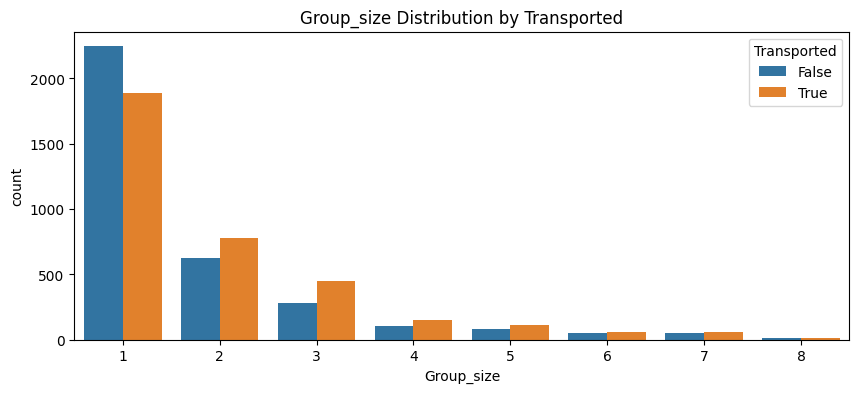

In [45]:
# plot distribution of Group_size
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group_size Distribution by Transported')
plt.show()

The difference in the distribution of Transported shows up especially in smaller group size. Inspired by this, we can create another feature indicating whether the passenger travels alone.

In [46]:
# create Solo_travelling feature
for df in [train, test]: 
    df['Solo_travelling'] = (df['Group_size']==1).astype(int)

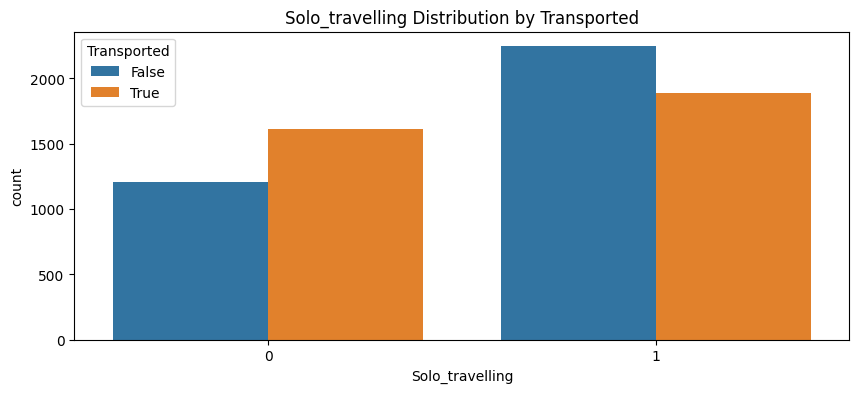

In [47]:
# plot distribution of Solo_travelling
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo_travelling', hue='Transported')
plt.title('Solo_travelling Distribution by Transported')
plt.show()

The difference in the distribution of Transported across Solo_travelling categories indicates that Solo_travelling is a candidate feature.

### Expenditure

Expenditure could be an important feature that is correlated with Transported, as passengers with more spending are generally richer and have more chance of being transported.

In [48]:
# create Has_expenditure feature
for df in [train, test]: 
    df['Has_spending'] = (df['Expenditure']==0).astype(int)

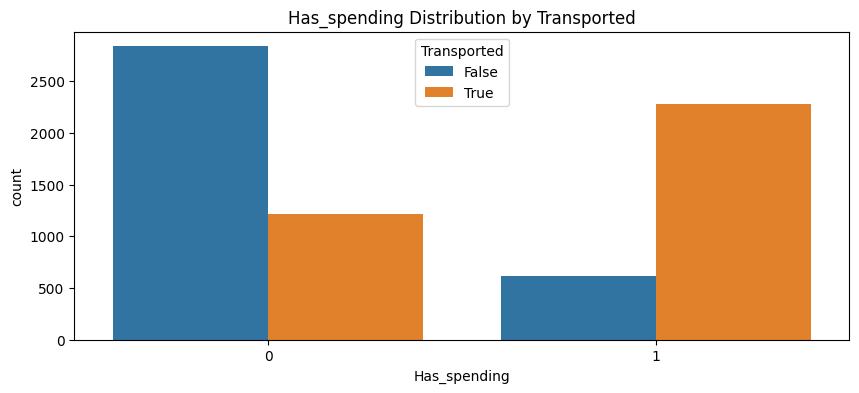

In [49]:
# plot distribution of Has_spending
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Has_spending', hue='Transported')
plt.title('Has_spending Distribution by Transported')
plt.show()

The difference in the distribution of Transported across Has_spending categories indicates that Has_spending is a candidate feature. 

### Age

Although Age takes numerical values, it is a nominal variable. To better capture the relationship between Age and Transported, we can bin similar ages into one age group.

In [50]:
# create Age_group feature
for df in [train, test]: 
    df['Age_group'] = np.nan
    df.loc[df['Age']<=12,'Age_group']='Age_0-12'
    df.loc[(df['Age']>12) & (df['Age']<=18),'Age_group'] = 'Age_13-18'
    df.loc[(df['Age']>18) & (df['Age']<=25),'Age_group'] = 'Age_19-25'
    df.loc[(df['Age']>25) & (df['Age']<=30),'Age_group'] = 'Age_26-30'
    df.loc[(df['Age']>30) & (df['Age']<=50),'Age_group'] = 'Age_31-50'
    df.loc[df['Age']>50,'Age_group']='Age_51+'

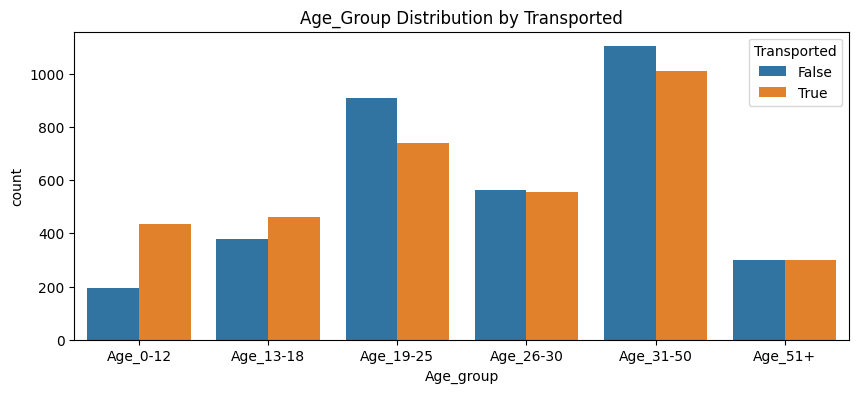

In [51]:
# plot distribution of Age_group
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-18','Age_19-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age_Group Distribution by Transported')
plt.show()

The difference in the distribution of Transported indeed shows up in several age groups, especially in the early stage of life.

### Cabin

Cabin is compose of 3 parts of information, so needs to be split before further analysis.

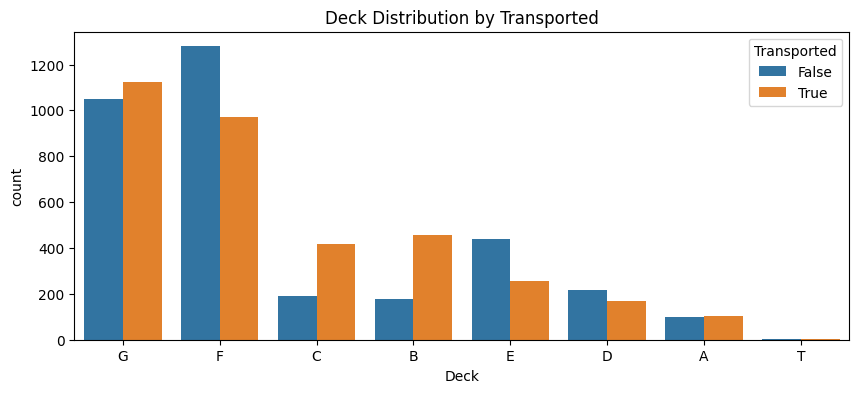

In [52]:
# plot distribution of Deck
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Deck', hue='Transported')
plt.title('Deck Distribution by Transported')
plt.show()

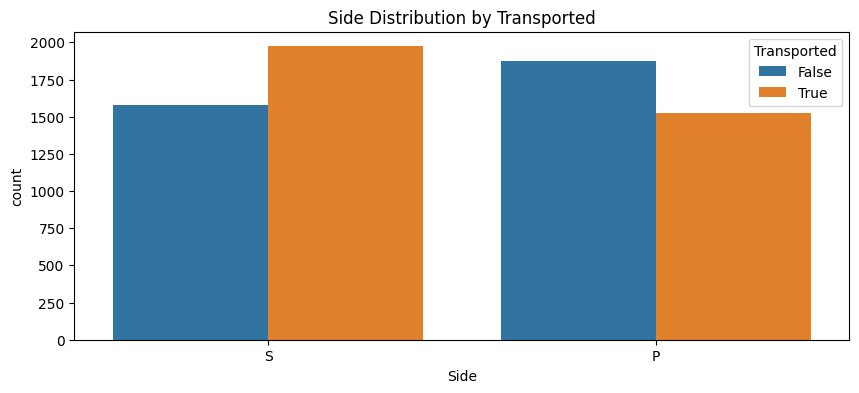

In [53]:
# plot distribution of Side
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Side', hue='Transported')
plt.title('Side Distribution by Transported')
plt.show()

In [54]:
df['Cabin_num'].nunique()

975

Due to the large number of unique categories in Cabin_num, we can similarly bin them into different groups.

In [55]:
# create Cabin_region feature
for df in [train, test]:
    df['Cabin_num'] = df['Cabin_num'].astype(int)
    df['Cabin_region'] = np.nan
    df.loc[df['Cabin_num']<300,'Cabin_region']='1'
    df.loc[(df['Cabin_num']>=300) & (df['Cabin_num']<600),'Cabin_region']='2'
    df.loc[(df['Cabin_num']>=600) & (df['Cabin_num']<900),'Cabin_region']='3'
    df.loc[(df['Cabin_num']>=900) & (df['Cabin_num']<1200),'Cabin_region']='4'
    df.loc[(df['Cabin_num']>=1200) & (df['Cabin_num']<1500),'Cabin_region']='5'
    df.loc[(df['Cabin_num']>=1500) & (df['Cabin_num']<1800),'Cabin_region']='6'
    df.loc[df['Cabin_num']>=1800,'Cabin_region']='7'

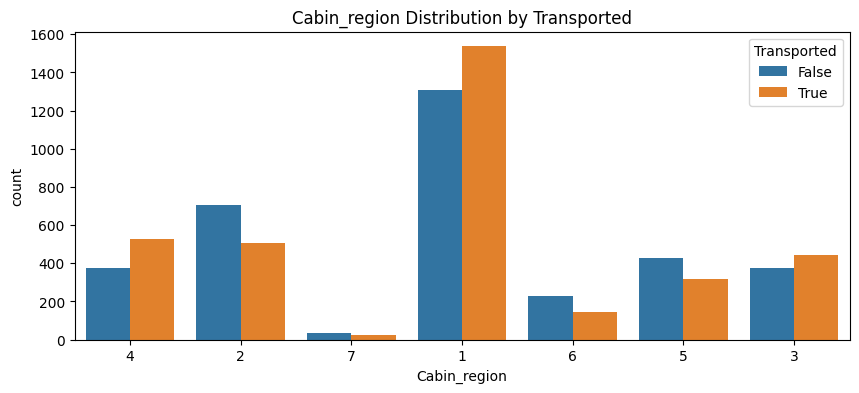

In [56]:
# plot distribution of Cabin_region
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Cabin_region', hue='Transported')
plt.title('Cabin_region Distribution by Transported')
plt.show()

All features generated from Cabin show some extent of difference in distribution of Transported.

### Convert Feature Format

Categorical and boolean features need to be converted to numberical features before being used for model building.

In [57]:
train.nunique()

PassengerId        6954
HomePlanet            3
CryoSleep             2
Cabin              5441
Destination           3
Age                  80
VIP                   2
RoomService        1105
FoodCourt          1312
ShoppingMall        978
Spa                1173
VRDeck             1136
Transported           2
Group              5215
Deck                  8
Cabin_num          1747
Side                  2
Expenditure        1996
Surname            2124
Group_size            8
Solo_travelling       2
Has_spending          2
Age_group             6
Cabin_region          7
dtype: int64

In [58]:
# convert categorical features
features_cat = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Group_size', 'Age_group', 'Cabin_region']
for feature in features_cat:
    train[pd.get_dummies(train[feature], prefix=feature).columns] = pd.get_dummies(train[feature], prefix=feature)
    test[pd.get_dummies(test[feature], prefix=feature).columns] = pd.get_dummies(test[feature], prefix=feature)
    if len(pd.get_dummies(train[feature], prefix=feature).columns) != len(pd.get_dummies(test[feature], prefix=feature).columns):
        print(f'{feature} has different categories in training and test set')
        print(f'Categories in training set: {pd.get_dummies(train[feature], prefix=feature).columns}')
        print(f'Categories in test set: {pd.get_dummies(test[feature], prefix=feature).columns}')

Deck has different categories in training and test set
Categories in training set: Index(['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_T'],
      dtype='object')
Categories in test set: Index(['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G'], dtype='object')
Group_size has different categories in training and test set
Categories in training set: Index(['Group_size_1', 'Group_size_2', 'Group_size_3', 'Group_size_4',
       'Group_size_5', 'Group_size_6', 'Group_size_7', 'Group_size_8'],
      dtype='object')
Categories in test set: Index(['Group_size_1', 'Group_size_2', 'Group_size_3', 'Group_size_4',
       'Group_size_5', 'Group_size_6', 'Group_size_7'],
      dtype='object')


In [59]:
# add missing categories to test set
missing_features = ['Deck_T', 'Group_size_8']
for feature in missing_features:
    test.insert(loc = list(train.columns).index(feature), column = feature, value = pd.Series([0]*len(test)))

In [60]:
# convert boolean features
features_boolean = ['CryoSleep', 'VIP', 'Solo_travelling', 'Has_spending']
for feature in features_boolean:
    train[feature] = train[feature].astype(int)
    test[feature] = test[feature].astype(int)

### Drop Irrelevant Features

The following features can be dropped, as they are either too specific to provide useful information for model training, or has been superseded by its dummy features.

In [61]:
# drop features for training set
train = train.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Age', 'Group', 'Deck', 'Cabin_num', 'Side', 
                    'Expenditure', 'Surname', 'Group_size', 'Age_group', 'Cabin_region'], axis=1)
train.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Solo_travelling,Has_spending,...,Age_group_Age_26-30,Age_group_Age_31-50,Age_group_Age_51+,Cabin_region_1,Cabin_region_2,Cabin_region_3,Cabin_region_4,Cabin_region_5,Cabin_region_6,Cabin_region_7
0,0,0,0.0,55.0,0.0,656.0,0.0,False,1,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0.0,1195.0,31.0,0.0,0.0,False,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0.0,0.0,0.0,0.0,0.0,True,0,1,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0.0,2.0,289.0,976.0,0.0,True,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0.0,0.0,0.0,0.0,0.0,True,0,1,...,0,1,0,1,0,0,0,0,0,0


In [62]:
# drop features for test set
test = test.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Age', 'Group', 'Deck', 'Cabin_num', 'Side', 
                    'Expenditure', 'Surname', 'Group_size', 'Age_group', 'Cabin_region'], axis=1)
test.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Solo_travelling,Has_spending,...,Age_group_Age_26-30,Age_group_Age_31-50,Age_group_Age_51+,Cabin_region_1,Cabin_region_2,Cabin_region_3,Cabin_region_4,Cabin_region_5,Cabin_region_6,Cabin_region_7
0,0,0,417.0,349.0,634.0,3.0,1057.0,True,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,4.0,904.0,0.0,0.0,1.0,False,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0.0,0.0,0.0,0.0,0.0,False,1,1,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0.0,338.0,436.0,0.0,0.0,True,1,0,...,0,1,0,1,0,0,0,0,0,0
4,1,0,0.0,0.0,0.0,0.0,0.0,True,0,1,...,0,1,0,1,0,0,0,0,0,0


## EDA and Feature Selection
<a class="anchor" id="featureselection"></a>

After the existing features have been transformed and new features have been created, we can proceed with feature selection.

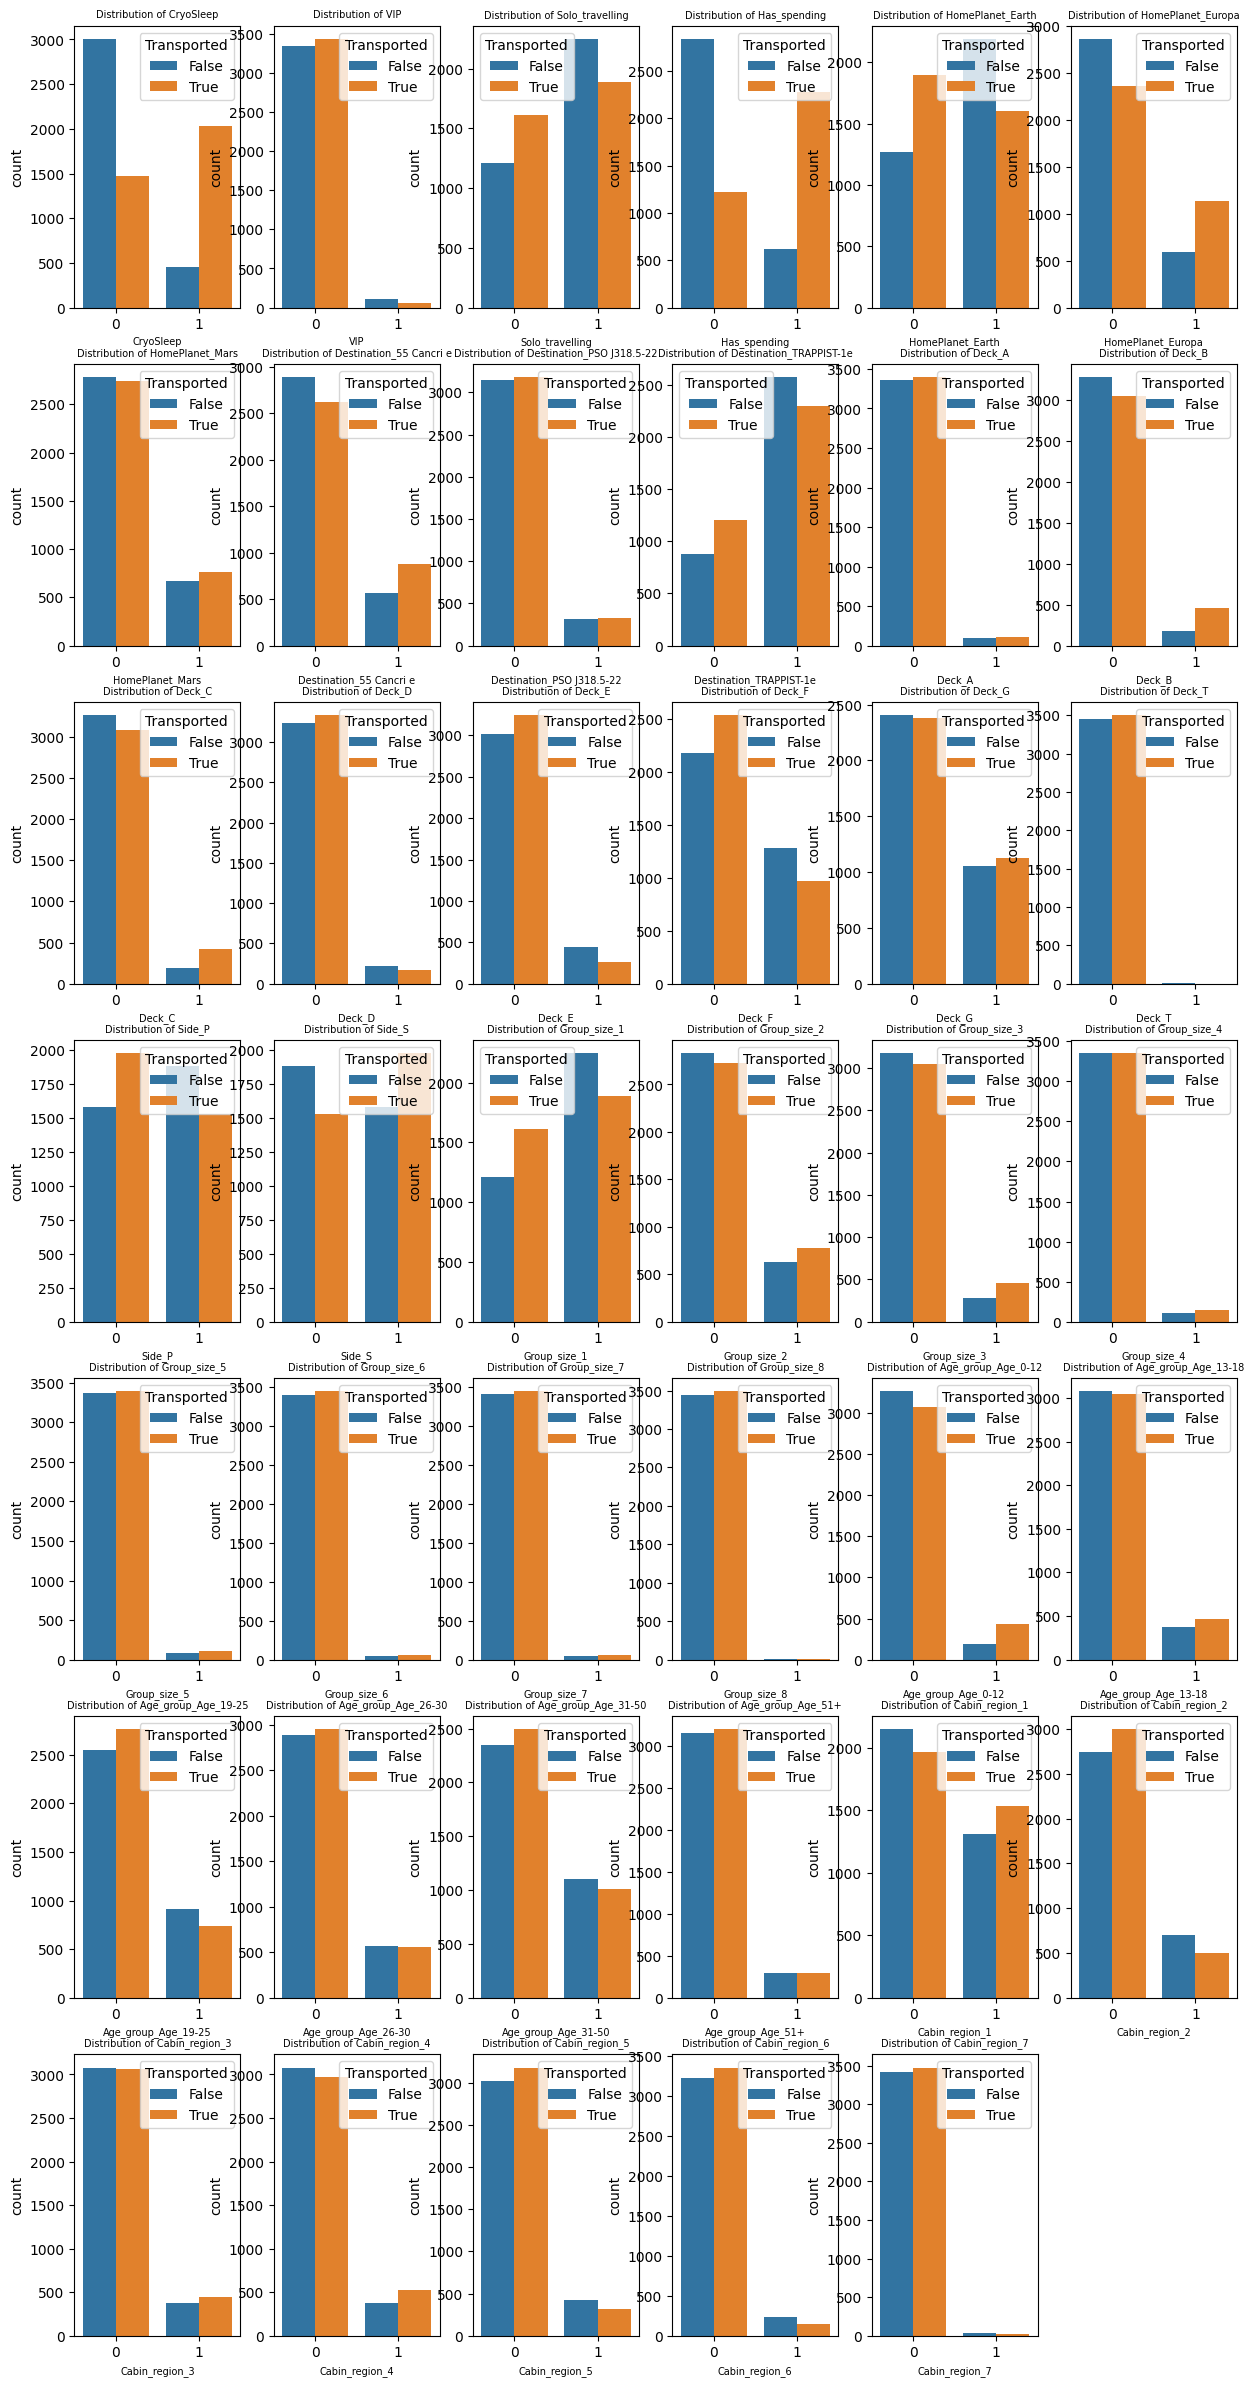

In [63]:
# plot categorical features
plt.figure(figsize=(15, 30))
for index, var in enumerate(train.columns[~train.columns.isin(expenditure_features+['Transported'])]):
    plt.subplot(7, 6, index+1)
    sns.countplot(data=train, x=var, hue="Transported")
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

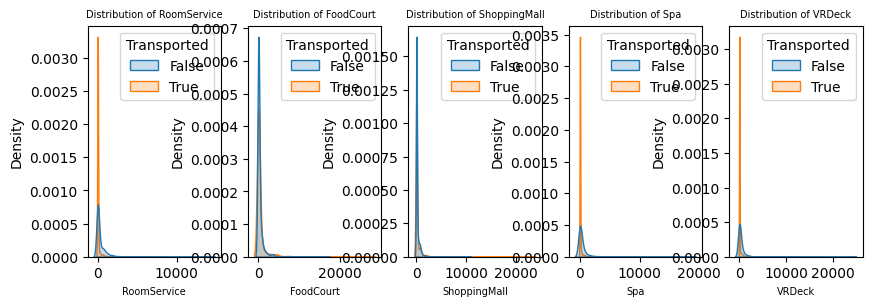

In [64]:
# plot numerical features
plt.figure(figsize=(10, 3))
for index, var in enumerate(expenditure_features):
    plt.subplot(1, 5, index+1)
    sns.kdeplot(data=train, x=var, hue="Transported", fill=True)
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

As these expenditure features all approximate a log-normal distribution, we can apply log transformation on them.

In [65]:
# apply log transform
for col in expenditure_features:
    train[col] = np.log(1+train[col])
    test[col] = np.log(1+test[col])

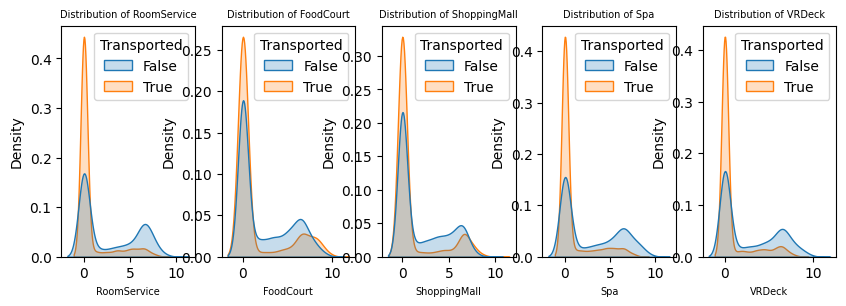

In [66]:
# plot numerical features
plt.figure(figsize=(10, 3))
for index, var in enumerate(expenditure_features):
    plt.subplot(1, 5, index+1)
    sns.kdeplot(data=train, x=var, hue="Transported", fill=True)
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

In [67]:
# identify features having a Pearson correlation of less than 0.05 with Transported
train.corr()['Transported'][np.abs(train.corr()['Transported'])<0.05]

VIP                         -0.038717
HomePlanet_Mars              0.027215
Destination_PSO J318.5-22    0.001901
Deck_A                       0.003963
Deck_D                      -0.030561
Deck_G                       0.018189
Deck_T                      -0.016272
Group_size_2                 0.049756
Group_size_4                 0.033836
Group_size_5                 0.023591
Group_size_6                 0.001495
Group_size_7                 0.008293
Group_size_8                -0.000389
Age_group_Age_13-18          0.033271
Age_group_Age_26-30         -0.006810
Age_group_Age_31-50         -0.033764
Age_group_Age_51+           -0.002546
Cabin_region_3               0.027544
Cabin_region_7              -0.017328
Name: Transported, dtype: float64

Both EDA and Pearson correlation suggest that the above features do not have high correlation with Transported, and thus can be excluded from modeling training.

In [68]:
selected_features = train.corr()['Transported'][np.abs(train.corr()['Transported'])>=0.05].index.tolist()

## Model Building
<a class="anchor" id="modelbuilding"></a>

The following models have been trained and tuned: Logistic Regression, K Nearest Neighbors, Support Vector Machine, Random Forest, and XGBoost, which cover a wide variety of machine learning algorithms.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

In [70]:
# split dataset for training
X_train = train[selected_features]
X_train = X_train.drop(['Transported'], axis=1)
y_train = train['Transported']

X_test = test[selected_features]
X_test = X_test.drop(['Transported'], axis=1)
y_test = test['Transported']

In [71]:
# create a dataframe to store accuracy scores
model_performance = pd.DataFrame({'Training_Accuracy':[], 'Test_Accuracy':[]})

### Logistic Regression

In [72]:
# baseline model
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
print(f'Accuracy of baseline logistic regression on training set: {np.round(accuracy_score(y_train, lr.predict(X_train)), 4)}')
print(f'Accuracy of baseline logistic regression on test set: {np.round(accuracy_score(y_test, lr.predict(X_test)), 4)}')

Accuracy of baseline logistic regression on training set: 0.7808
Accuracy of baseline logistic regression on test set: 0.7752


In [73]:
model_performance.loc['Logistic Regression'] = [0.7808, 0.7752]

### KNN

In [74]:
# baseline model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Accuracy of baseline KNN on training set: {np.round(accuracy_score(y_train, knn.predict(X_train)), 4)}')
print(f'Accuracy of baseline KNN on test set: {np.round(accuracy_score(y_test, knn.predict(X_test)), 4)}')

Accuracy of baseline KNN on training set: 0.8387
Accuracy of baseline KNN on test set: 0.766


In [75]:
# hyperparameter tuning
parameters = {
    'n_neighbors': [3, 5, 7, 9], # number of neighbors to use.
    'leaf_size': [20, 30, 40], # leaf size passed to BallTree or KDTree
    'p': [1,2], # power parameter for the Minkowski metric
    'weights': ['uniform', 'distance'], # weight function used in prediction
    'metric': ['minkowski', 'chebyshev'] # metric to use for distance computation
}

KNN_model = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN_model, param_grid=parameters, cv=5, scoring = 'accuracy', n_jobs=-1, verbose=2)
KNN_grid.fit(X_train, y_train)
print('Best Parameters : ', KNN_grid.best_params_)
print('Best Accuracy : ', KNN_grid.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters :  {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best Accuracy :  0.7878932914056964


In [76]:
# model fitting and evaluation
knn = KNeighborsClassifier(**KNN_grid.best_params_)
knn.fit(X_train, y_train)
print(f'Accuracy of tuned KNN on training set: {np.round(accuracy_score(y_train, knn.predict(X_train)), 4)}')
print(f'Accuracy of tuned KNN on test set: {np.round(accuracy_score(y_test, knn.predict(X_test)), 4)}')

Accuracy of tuned KNN on training set: 0.8246
Accuracy of tuned KNN on test set: 0.7763


In [77]:
model_performance.loc['KNN'] = [0.8246, 0.7763]

Slight improvement on test set accuracy is achieved through hyperparameter tuning.

### SVM

In [78]:
# baseline model
svm = SVC(random_state=0)
svm.fit(X_train, y_train)
print(f'Accuracy of baseline SVM on training set: {np.round(accuracy_score(y_train, svm.predict(X_train)), 4)}')
print(f'Accuracy of baseline SVM on test set: {np.round(accuracy_score(y_test, svm.predict(X_test)), 4)}')

Accuracy of baseline SVM on training set: 0.8072
Accuracy of baseline SVM on test set: 0.7878


In [79]:
# hyperparameter tuning
parameters = {
    "kernel": ['linear', 'poly', 'rbf'], # specifies the kernel type to be used
    "gamma": ['scale', 'auto'], # kernel coefficient
    "degree" : [2, 3, 4], # degree of the polynomial kernel function
    "C" : [0.1, 1, 10] # regularization parameter
}

SVM_model = SVC(random_state=0)
SVM_grid = GridSearchCV(SVM_model, param_grid=parameters, cv=5, scoring = 'accuracy', n_jobs=-1, verbose=2)
SVM_grid.fit(X_train, y_train)
print('Best Parameters : ', SVM_grid.best_params_)
print('Best Accuracy : ', SVM_grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters :  {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best Accuracy :  0.8061562252714005


In [80]:
# model fitting and evaluation
svm = SVC(**SVM_grid.best_params_, random_state=0)
svm.fit(X_train, y_train)
print(f'Accuracy of Tuned SVM on training set: {np.round(accuracy_score(y_train, svm.predict(X_train)), 4)}')
print(f'Accuracy of Tuned SVM on test set: {np.round(accuracy_score(y_test, svm.predict(X_test)), 4)}')

Accuracy of Tuned SVM on training set: 0.8178
Accuracy of Tuned SVM on test set: 0.7867


In [81]:
model_performance.loc['SVM'] = [0.8072, 0.7878]

Hyperparameter tuning does not really improve the model performance.

### Random Forest

In [82]:
# baseline model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print(f'Accuracy of baseline random forest on training set: {np.round(accuracy_score(y_train, rf.predict(X_train)), 4)}')
print(f'Accuracy of baseline random forest on test set: {np.round(accuracy_score(y_test, rf.predict(X_test)), 4)}')

Accuracy of baseline random forest on training set: 0.9405
Accuracy of baseline random forest on test set: 0.789


In [83]:
# hyperparameter tuning
parameters = {
    "n_estimators": [50, 100, 150, 200], # the number of trees in the forest
    "max_depth": [5, 10, 15], # the maximum depth of the tree
    "min_samples_leaf" : [1, 2, 3, 4], # the minimum number of samples required to be at a leaf node
    "min_samples_split" : [2, 3, 4, 5] # the minimum number of samples required to split an internal node
}

RFC_model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_model, param_grid=parameters, cv=5, scoring = 'accuracy', n_jobs=-1, verbose=2)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print('Best Accuracy : ', RFC_grid.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best Accuracy :  0.8096074973234927


In [84]:
# model fitting and evaluation
rf = RandomForestClassifier(**RFC_grid.best_params_, random_state=0)
rf.fit(X_train, y_train)
print(f'Accuracy of tuned random forest on training set: {np.round(accuracy_score(y_train, rf.predict(X_train)), 4)}')
print(f'Accuracy of tuned random forest on test set: {np.round(accuracy_score(y_test, rf.predict(X_test)), 4)}')

Accuracy of tuned random forest on training set: 0.8572
Accuracy of tuned random forest on test set: 0.7895


In [85]:
model_performance.loc['Random Forest'] = [0.8572, 0.7895]

Slight improvement on test set accuracy is achieved through hyperparameter tuning.

### XGBoost

In [86]:
# baseline model
xgb =  XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
print(f'Accuracy of baseline XGBoost on training set: {np.round(accuracy_score(y_train, xgb.predict(X_train)), 4)}')
print(f'Accuracy of baseline XGBoost on test set: {np.round(accuracy_score(y_test, xgb.predict(X_test)), 4)}')

Accuracy of baseline XGBoost on training set: 0.9008
Accuracy of baseline XGBoost on test set: 0.7936


In [87]:
# hyperparameter tuning
parameters_xgb = {
    'eta' : [0.2, 0.3, 0.4, 0.5,], # step size shrinkage used in update to prevents overfitting
    'gamma': [0, 0.5, 1.0, 1.5], # minimum loss reduction required to make a further partition on a leaf node of the tree.
    'max_depth' : [1, 3, 6, 9], # maximum depth of a tree
    'min_child_weight': [1, 3, 6, 9] # minimum sum of instance weight (hessian) needed in a child
}

XGB_model = XGBClassifier(random_state=0)
XGB_grid = GridSearchCV(XGB_model, param_grid=parameters_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
XGB_grid.fit(X_train, y_train)
print('Best Parameters : ', XGB_grid.best_params_)
print('Best Accuracy : ', XGB_grid.best_score_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best Parameters :  {'eta': 0.3, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1}
Best Accuracy :  0.8120520923304492


In [88]:
# model fitting and evaluation
xgb = XGBClassifier(**XGB_grid.best_params_, random_state=0)
xgb.fit(X_train, y_train)
print(f'Accuracy of tuned XGBoost on training set: {np.round(accuracy_score(y_train, xgb.predict(X_train)), 4)}')
print(f'Accuracy of tuned XGBoost on test set: {np.round(accuracy_score(y_test, xgb.predict(X_test)), 4)}')

Accuracy of tuned XGBoost on training set: 0.8316
Accuracy of tuned XGBoost on test set: 0.7976


In [89]:
model_performance.loc['XGBoost'] = [0.8316, 0.7976]

Slight improvement on test set accuracy is achieved through hyperparameter tuning.

## Model Evaluation and Results Presentation
<a class="anchor" id="modelevaluation"></a>

As the last step, the outcome of each model will be presented and compared.

In [90]:
model_performance['Model'] = model_performance.index
model_performance

,Training_Accuracy,Test_Accuracy,Model
Logistic Regression,0.7808,0.7752,Logistic Regression
KNN,0.8246,0.7763,KNN
SVM,0.8072,0.7878,SVM
Random Forest,0.8572,0.7895,Random Forest
XGBoost,0.8316,0.7976,XGBoost


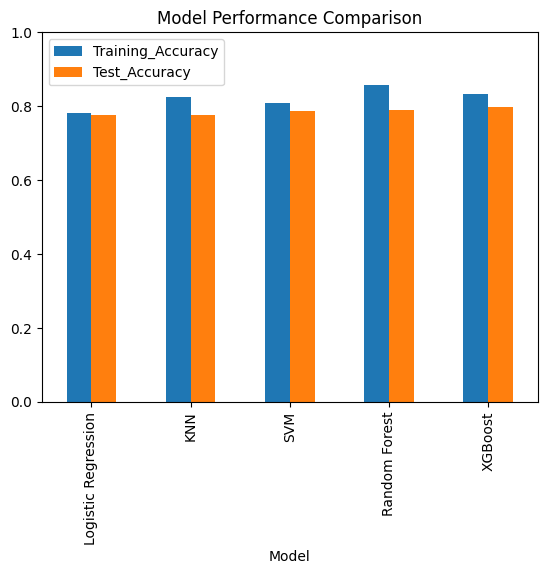

In [91]:
# present the accuracy scores in a bar chart
model_performance.plot(x="Model", y=["Training_Accuracy", "Test_Accuracy"], kind="bar")
plt.title('Model Performance Comparison')
plt.ylim([0, 1])
plt.show()

#### These few models exhibit very similar performance with Random Forest having a slightly higher accuracy of 0.8572 on the training set and XGBoost having a slightly higher accuracy of 0.7976 on the test set.

# Question 2: Webscraping (Optional)
<a class="anchor" id="question2"></a>

Scrape the first 5 pages of https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating
An example of what the result should look like is provided in the attached 'imdb.csv' file.
Do note that certain variables are missing for certain movies (e.g certain movies might not have a "metascore" value)
If you are unable to scrape all variables or all movies, just scrape as much as you can.


In [41]:
# import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [90]:
# create a dataframe to store the results
result_df = pd.DataFrame({'title':[], 'year':[], 'certificate':[], 'runtime':[], 'genre':[], 'description':[], 'rating':[], 'metascore':[], 
              'director':[], 'stars':[], 'votes':[], 'gross':[]})

In [91]:
# define a helper function to extract the movie information from each movie block scraped
def extract_content(movie_containers):
    for container in movie_containers:
        title = container.h3.a.text
        year = container.h3.find("span", class_="lister-item-year").text[-5:-1] if container.h3.find("span", class_="lister-item-year") else ''
        certificate = container.p.find("span", class_="certificate").text if container.p.find("span", class_="certificate") else ''
        runtime = container.p.find("span", class_="runtime").text if container.p.find("span", class_="runtime") else ''
        genre = container.p.find("span", class_="genre").text.strip() if container.p.find("span", class_="genre") else ''
        description = container.find_all("p", class_="text-muted")[1].text.strip() if len(container.find_all("p", class_="text-muted"))>1 else ''
        rating = container.find("div", class_="inline-block ratings-imdb-rating").strong.text if container.find("div", class_="inline-block ratings-imdb-rating") else ''
        metascore = container.find("span", class_="metascore").text.strip() if container.find("span", class_="metascore") else ''
        directors_stars = container.find("p", class_="").find_all()
        directors, stars, isStar = [], [], False
        for element in directors_stars:
            if element==container.find("p", class_="").find('span'):
                isStar = True
            elif isStar:
                stars += [element.text]
            else:
                directors += [element.text]
        stars = ', '.join(stars)
        directors = ', '.join(directors)
        if ', ' in directors:
            directors = 'Directors: ' + directors
        votes = container.find_all("span", attrs={"name": "nv"})[0].text
        gross = container.find_all("span", attrs={"name": "nv"})[1].text if len(container.find_all("span", attrs={"name": "nv"}))>1 else ''

        result_df.loc[len(result_df)] = [title,year,certificate,runtime,genre,description,rating,metascore,directors,stars,votes,gross]

In [92]:
# scrape the first 5 pages on IMDb using url
start = 1
for i in range(5):
    url = f'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start={start+i*100}&ref_=adv_nxt'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    movie_containers = soup.find_all("div", class_="lister-item-content")
    extract_content(movie_containers)

In [93]:
# print out your scraped dataframe
result_df

,title,year,certificate,runtime,genre,description,rating,metascore,director,stars,votes,gross
0,The Shawshank Redemption,1994,R(A),142 min,Drama,"Over the course of several years, two convicts...",9.3,82,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","2,787,740",$28.34M
1,The Godfather,1972,M18,175 min,"Crime, Drama","Don Vito Corleone, head of a mafia family, dec...",9.2,100,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","1,941,362",$134.97M
2,The Dark Knight,2008,PG,152 min,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,9.0,84,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","2,767,217",$534.86M
3,Schindler's List,1993,R(A),195 min,"Biography, Drama, History","In German-occupied Poland during World War II,...",9.0,95,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...","1,402,300",$96.90M
4,The Godfather Part II,1974,PG,202 min,"Crime, Drama",The early life and career of Vito Corleone in ...,9.0,90,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall, Dian...","1,319,174",$57.30M
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Shaun of the Dead,2004,R21,99 min,"Comedy, Horror","The uneventful, aimless lives of a London elec...",7.9,76,Edgar Wright,"Simon Pegg, Nick Frost, Kate Ashfield, Lucy Davis","577,374",$13.54M
496,Children of Men,2006,NC-16,109 min,"Action, Drama, Sci-Fi","In 2027, in a chaotic world in which women hav...",7.9,84,Alfonso Cuarón,"Julianne Moore, Clive Owen, Chiwetel Ejiofor, ...","515,621",$35.55M
497,Marriage Story,2019,M18,137 min,"Drama, Romance",Noah Baumbach's incisive and compassionate loo...,7.9,94,Noah Baumbach,"Adam Driver, Scarlett Johansson, Julia Greer, ...","330,516",$2.00M
498,Cat on a Hot Tin Roof,1958,PG,108 min,Drama,Brick is an alcoholic ex-football player who d...,7.9,84,Richard Brooks,"Elizabeth Taylor, Paul Newman, Burl Ives, Jack...","52,030",$17.57M
